# 장애인 콜택시 대기시간 예측 프로젝트 데이터 처리
## 목표
- 기상 예보를 바탕으로, 장애인 콜택시 평균 대기 시간을 예측하기.
- 장애인 이동권 개선을 위하여서, 콜택시 대기시간을 예측하는 프로젝트이다.  
- 이를 통하여 장애인 콜택시를 이용하는 고객들의 불편사항을 개선하고 서비스의 품질을 높여 교통약자의 이동 편의 증진에 기여한다.
### 목차
1. 데이터 처리  
2. 데이터 분석
3. **머신러닝 모델링**   
    - (나머지 3달 데이터는 테스트, 나머지는 학습데이터로 활용)  
    - MAE, MAPE를 사용해 성능 높은 모델 선정  
- 데이터 출처 : [서울시설공단_장애인콜택시 일별 이용현황](https://www.data.go.kr/data/15057705/openapi.do)  

## 라이브러리 불러오기

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# 회귀 모델
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 회귀 성능 튜닝
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# 회귀 평가
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score

# 딥러닝
import tensorflow as tf

import warnings
warnings.filterwarnings(action='ignore') # pd 경고메시지 생략

## 데이터 불러오기

In [4]:
# df = pd.read_csv('./data/df.csv')
df = joblib.load('./data/df.pkl')
df.head()

,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),year,month,week,weekday,holiday,7days_waiting_time
time,,,,,,,,,,,,,,,,,,
2015-01-01,213,1023,924,23.2,2427,10764,-2.0,-8.9,0.0,63.0,28.0,9.07,2015,1,1,3,1.0,NaN
2015-01-02,420,3158,2839,17.2,2216,8611,2.4,-9.2,0.0,73.0,37.0,8.66,2015,1,1,4,0.0,NaN
2015-01-03,209,1648,1514,26.2,2377,10198,8.2,0.2,0.0,89.0,58.0,5.32,2015,1,1,5,1.0,NaN
2015-01-04,196,1646,1526,24.5,2431,10955,7.9,-0.9,0.0,95.0,52.0,6.48,2015,1,1,6,1.0,NaN
2015-01-05,421,4250,3730,26.2,2214,8663,4.1,-7.4,3.4,98.0,29.0,10.47,2015,1,2,0,0.0,NaN


#### NaN 값 처리, 타입 변경하기

In [5]:
drop_col = '7days_waiting_time'
df = df.drop(drop_col, axis=1)

In [6]:
df

,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),year,month,week,weekday,holiday
time,,,,,,,,,,,,,,,,,
2015-01-01,213,1023,924,23.2,2427,10764,-2.0,-8.9,0.0,63.0,28.0,9.07,2015,1,1,3,1.0
2015-01-02,420,3158,2839,17.2,2216,8611,2.4,-9.2,0.0,73.0,37.0,8.66,2015,1,1,4,0.0
2015-01-03,209,1648,1514,26.2,2377,10198,8.2,0.2,0.0,89.0,58.0,5.32,2015,1,1,5,1.0
2015-01-04,196,1646,1526,24.5,2431,10955,7.9,-0.9,0.0,95.0,52.0,6.48,2015,1,1,6,1.0
2015-01-05,421,4250,3730,26.2,2214,8663,4.1,-7.4,3.4,98.0,29.0,10.47,2015,1,2,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,669,5635,4654,44.4,2198,8178,-0.3,-5.4,0.1,92.0,40.0,10.86,2022,12,52,1,0.0
2022-12-28,607,5654,4648,44.8,2161,7882,1.7,-7.8,0.0,71.0,34.0,10.88,2022,12,52,2,0.0
2022-12-29,581,5250,4247,52.5,2229,8433,2.1,-4.0,0.0,87.0,38.0,10.84,2022,12,52,3,0.0


# 데이터 나누기
* 시계열 데이터 특성에 맞게 분할  
* 마지막 91일(3개월) 데이터를 검증셋으로 사용

#### x,y 분리하기

In [7]:
target = 'waiting_time'

x = df.drop(target, axis=1)
y = df.loc[:,target]

#### 가변수화

In [8]:
# 가변수화
dumm_cols = ['year','month','week','weekday','holiday']
x = pd.get_dummies(x, columns=dumm_cols, drop_first=True)

In [9]:
display(x.head(2))
display(y.head(2))

,car_cnt,request_cnt,ride_cnt,fare,distance,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),...,week_51,week_52,week_53,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,holiday_1.0
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01,213,1023,924,2427,10764,-2.0,-8.9,0.0,63.0,28.0,...,0,0,0,0,0,1,0,0,0,1
2015-01-02,420,3158,2839,2216,8611,2.4,-9.2,0.0,73.0,37.0,...,0,0,0,0,0,0,1,0,0,0


time
2015-01-01    23.2
2015-01-02    17.2
Name: waiting_time, dtype: float64

In [10]:
y.head(2)

time
2015-01-01    23.2
2015-01-02    17.2
Name: waiting_time, dtype: float64

#### train, validation 나누기

In [11]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 92, shuffle=False)

In [12]:
x_train

,car_cnt,request_cnt,ride_cnt,fare,distance,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),...,week_51,week_52,week_53,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,holiday_1.0
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01,213,1023,924,2427,10764,-2.0,-8.9,0.0,63.0,28.0,...,0,0,0,0,0,1,0,0,0,1
2015-01-02,420,3158,2839,2216,8611,2.4,-9.2,0.0,73.0,37.0,...,0,0,0,0,0,0,1,0,0,0
2015-01-03,209,1648,1514,2377,10198,8.2,0.2,0.0,89.0,58.0,...,0,0,0,0,0,0,0,1,0,1
2015-01-04,196,1646,1526,2431,10955,7.9,-0.9,0.0,95.0,52.0,...,0,0,0,0,0,0,0,0,1,1
2015-01-05,421,4250,3730,2214,8663,4.1,-7.4,3.4,98.0,29.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,642,5947,5039,2236,8529,27.7,14.1,0.0,86.0,33.0,...,0,0,0,0,0,0,0,0,0,0
2022-09-27,667,6044,5087,2238,8585,25.8,16.3,0.0,84.0,48.0,...,0,0,0,1,0,0,0,0,0,0
2022-09-28,670,6182,5176,2258,8751,26.3,16.5,0.0,92.0,36.0,...,0,0,0,0,1,0,0,0,0,0


#### 정규화
- knn 사용을 위해서

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train_s = scaler.transform(x_train)
x_test_s = scaler.transform(x_train)

# 데이터 모델링

- MAE, MAPE로 성능 측정
- MAE와 MAPE는 모두 값이 작을수록 모델의 성능이 좋다는 것을 의미한다.

## ML

#### ML모델 선언

In [14]:
LR_model = LinearRegression()
KN_model = KNeighborsRegressor()
Tree_model = DecisionTreeRegressor()
RanF_model = RandomForestRegressor()
xg_model = XGBRegressor()
lg_model = LGBMRegressor()

models = {'LR_model':LR_model,
        'KN_model':KN_model,
        'Tree_model':Tree_model,
        'RanF_model':RanF_model,
        'xg_model':xg_model,
        'lg_model':lg_model}

#### 모델 학습 및 평가

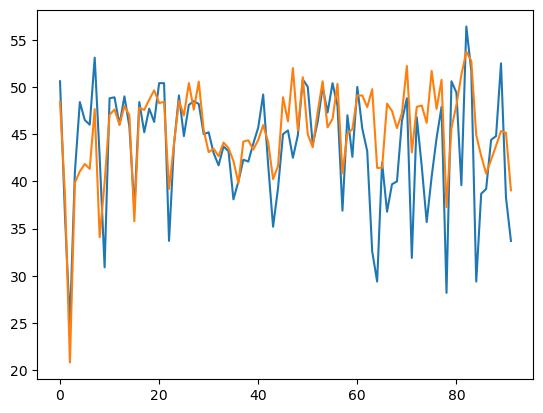

LR_model
MAE: 3.6528942177519723
MAPE: 0.09401200504295247
r2: 0.2924349906249316


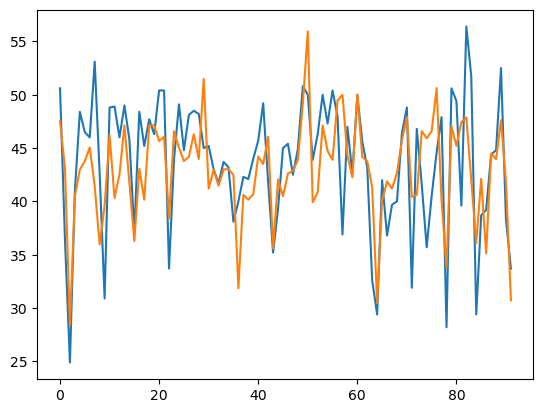

KN_model
MAE: 3.869347826086957
MAPE: 0.09227576659381302
r2: 0.37923278597131427


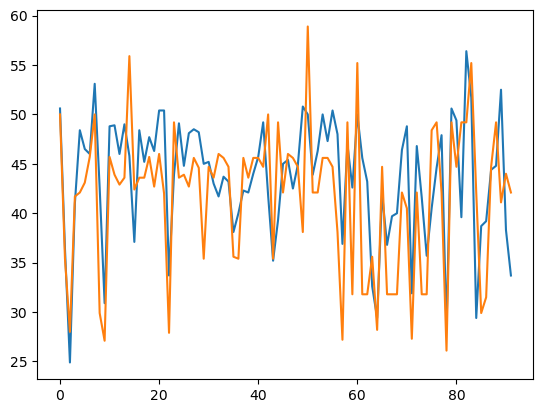

Tree_model
MAE: 4.945652173913043
MAPE: 0.11593326827746794
r2: 0.027993259338097043


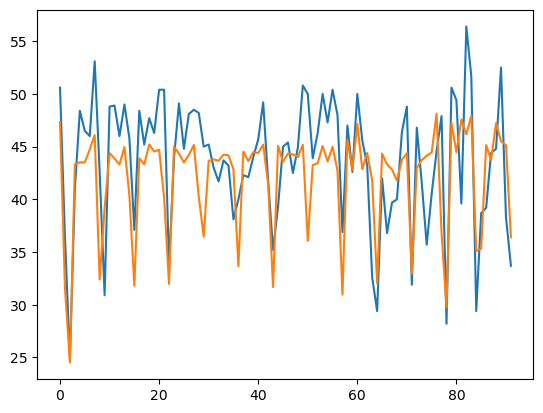

RanF_model
MAE: 3.940445652173914
MAPE: 0.09129580005154528
r2: 0.3746629948177993


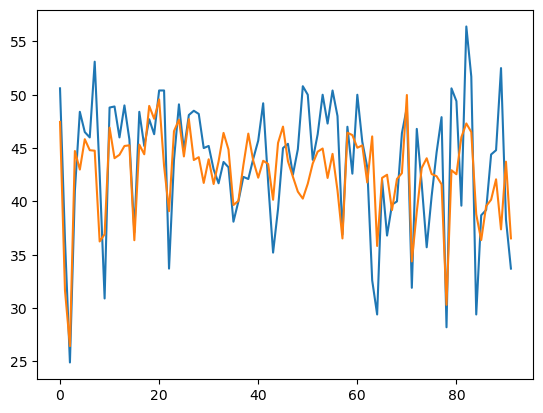

xg_model
MAE: 3.655454266589621
MAPE: 0.0855937064666454
r2: 0.3994210012946309
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2462
[LightGBM] [Info] Number of data points in the train set: 2831, number of used features: 87
[LightGBM] [Info] Start training from score 40.192794


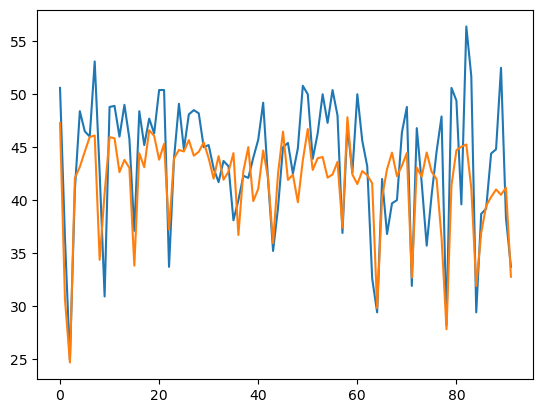

lg_model
MAE: 3.6000735258975345
MAPE: 0.0814122651463871
r2: 0.4236715067893774


In [15]:
results = []
for name, model in models.items():
    print("="*50)
    if model != 'KN_model':
        model.fit(x_train, y_train) # 모델 학습
        y_pred = model.predict(x_test) # 모델 예측
        model_mae = mae(y_test, y_pred)
        model_mape = mape(y_test, y_pred)
        model_r2 = r2_score(y_test, y_pred)
    else:
        model.fit(x_train_s, y_train)
        y_pred = model.predict(x_test_s)
        model_mae = mae(y_test, y_pred)
        model_mape = mape(y_test, y_pred)
        model_r2 = r2_score(y_test, y_pred)
        
    plt.plot(np.array(y_test))
    plt.plot(y_pred)
    plt.show()
    print(name)
    print('MAE:', model_mae)
    print('MAPE:', model_mape)
    print('r2:', model_r2)
    
    results.append([name, (model_mae, model_mape, model_r2)])

In [16]:
sorted(results, key=lambda x: x[1][2])

[['Tree_model',
  (4.945652173913043, 0.11593326827746794, 0.027993259338097043)],
 ['LR_model', (3.6528942177519723, 0.09401200504295247, 0.2924349906249316)],
 ['RanF_model', (3.940445652173914, 0.09129580005154528, 0.3746629948177993)],
 ['KN_model', (3.869347826086957, 0.09227576659381302, 0.37923278597131427)],
 ['xg_model', (3.655454266589621, 0.0855937064666454, 0.3994210012946309)],
 ['lg_model', (3.6000735258975345, 0.0814122651463871, 0.4236715067893774)]]

#### 모델 튜닝
- 해당부분, 공유를 통하여 문제 해결하면 좋을것 같다는 생각함

##### KNN 모델

In [24]:
# 파라미터 선언
param = {'n_neighbors': range(1, 500, 10),
        'metric': ['euclidean', 'manhattan']}

# Random Search 선언
model = GridSearchCV(KN_model,
                            param,
                            cv=3)
# 학습하기
model.fit(x_train_s, y_train)

# 중요 정보 확인
print('=' * 80)
print(model.cv_results_['mean_test_score'])
print('-' * 80)
print('최적파라미터:', model.best_params_)
print('-' * 80)
print('최고성능:', model.best_score_)
print('=' * 80)

# 예측하기
y_pred = model.predict(x_test_s)

[-2.05993709 -1.04302481 -1.12477906 -1.17074589 -1.12387798 -1.07464465
 -1.03051271 -0.98343548 -0.94726742 -0.94584421 -0.95820206 -0.96206168
 -0.97457585 -0.99015182 -1.00228369 -1.01766373 -1.03389351 -1.05618759
 -1.07514848 -1.09551611 -1.11371426 -1.13242232 -1.14872925 -1.16407717
 -1.17705556 -1.18933805 -1.20024178 -1.20903585 -1.2184043  -1.22699453
 -1.23367636 -1.23946951 -1.24289057 -1.24488031 -1.2473764  -1.24636937
 -1.244254   -1.24035184 -1.23473306 -1.23078081 -1.22809538 -1.22618139
 -1.2248215  -1.22378513 -1.22192793 -1.2199839  -1.21884367 -1.21866803
 -1.21814689 -1.21840471 -2.11462139 -1.08966177 -1.16586925 -1.19149695
 -1.14127335 -1.07881657 -1.02880008 -1.00209917 -0.99610971 -1.0050273
 -1.01129136 -1.01594422 -1.02770811 -1.04013621 -1.05436702 -1.07495726
 -1.09218626 -1.10888355 -1.12540001 -1.13874168 -1.15220786 -1.16445392
 -1.17752124 -1.18871421 -1.1991153  -1.20872901 -1.21802992 -1.22513921
 -1.23355205 -1.24064932 -1.24834002 -1.25323522 -1.

##### RandomForest 모델

In [25]:
# 파라미터 선언
# max_depth: 1~50
param = {'max_depth': range(1,51)}

# Random Search 선언
  # cv=5
  # n_iter=20
  # scoring='r2'
model = RandomizedSearchCV(RanF_model, # 기본 모델
                          param,       # 파라미터 범위
                          cv=5,        # K-Folde 개수
                          n_iter=20   # 랜덤하게 선택할 파라미터(조합) 개수
                          )
# 학습하기
model.fit(x_train, y_train)

# 중요 정보 확인
print('=' * 80)
print(model.cv_results_['mean_test_score'])
print('-' * 80)
print('최적파라미터:', model.best_params_)
print('-' * 80)
print('최고성능:', model.best_score_)
print('=' * 80)

# 예측하기
y_pred = model.predict(x_test)

print('MAE:', mae(y_test, y_pred))
print('MAPE:', mape(y_test, y_pred))
print('r2:', r2_score(y_test, y_pred))

[ 0.3660778   0.36711989  0.36032908  0.3724639   0.36449599  0.38285792
 -0.31357353 -0.02569268  0.34769432  0.36689404  0.38314596  0.37509901
  0.38831346  0.3851213   0.08252006  0.3737229   0.36701898  0.37351223
  0.37015259 -0.09125054]
--------------------------------------------------------------------------------
최적파라미터: {'max_depth': 25}
--------------------------------------------------------------------------------
최고성능: 0.3883134616354214
MAE: 3.766783107472244
MAPE: 0.08678263202818866


##### Decision Tree 모델

In [26]:
# 파라미터 선언
# max_depth: 1~50
param = {'max_depth': range(1,51)}

model = RandomizedSearchCV(Tree_model, # 기본 모델
                          param,       # 파라미터 범위
                          cv=5,        # K-Folde 개수
                          n_iter=20   # 랜덤하게 선택할 파라미터(조합) 개수
                          )
# 학습하기
model.fit(x_train, y_train)

# 중요 정보 확인
print('=' * 80)
print(model.cv_results_['mean_test_score'])
print('-' * 80)
print('최적파라미터:', model.best_params_)
print('-' * 80)
print('최고성능:', model.best_score_)
print('=' * 80)

# 예측하기
y_pred = model.predict(x_test)

print('MAE:', mae(y_test, y_pred))
print('MAPE:', mape(y_test, y_pred))
print('r2:', r2_score(y_test, y_pred))

[-0.27731646 -0.22435112 -0.25386189 -0.03885857 -0.58151331 -0.22216245
 -0.17318676 -0.1520279  -0.12677627 -0.1969769   0.01740344 -0.17860942
 -0.17336109 -0.2625823  -0.20474584 -0.02442614 -0.29104582 -0.23050947
 -0.07239622 -0.1702444 ]
--------------------------------------------------------------------------------
최적파라미터: {'max_depth': 9}
--------------------------------------------------------------------------------
최고성능: 0.017403435084999752
MAE: 4.4703855458399495
MAPE: 0.10082196953606899


## DeapLearning

In [17]:
print(f"X shape : {x_train.shape}")
print(f"Y shape : {y_train.shape}")

X shape : (2831, 88)
Y shape : (2831,)


#### 모델 구조 생성

In [36]:
X = tf.keras.Input(shape=[88])

# 은닉 레이어 
H = tf.keras.layers.Dense(256)(X)
H = tf.keras.layers.BatchNormalization()(H)
H = tf.keras.layers.Activation('swish')(H)

# 여기 부분이 skip connection 레이어층 쌓기 부분
for i in range(10):
    H1 = tf.keras.layers.Dropout(0.6)(H)
    H1 = tf.keras.layers.Dense(1024)(H1)
    H1 = tf.keras.layers.BatchNormalization()(H1)
    H1 = tf.keras.layers.Activation("ReLU")(H1)
    
    H1 = tf.keras.layers.Dropout(0.6)(H)
    H1 = tf.keras.layers.Dense(512)(H1)
    H1 = tf.keras.layers.BatchNormalization()(H1)
    H1 = tf.keras.layers.Activation("ReLU")(H1)
    
    H1 = tf.keras.layers.Dropout(0.6)(H1)
    H1 = tf.keras.layers.Dense(256)(H1)
    H1 = tf.keras.layers.BatchNormalization()(H1)
    H = tf.keras.layers.Add()([H,H1])
    H = tf.keras.layers.Activation("ReLU")(H)
Y = tf.keras.layers.Dense(1, activation="linear")(H)

dp_model = tf.keras.Model(X, Y)
dp_model.compile(loss=tf.keras.losses.mse, 
                 metrics=tf.keras.metrics.mae,
                optimizer = 'Adam')
dp_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 88)]                 0         []                            
                                                                                                  
 dense_57 (Dense)            (None, 256)                  22784     ['input_3[0][0]']             
                                                                                                  
 batch_normalization_55 (Ba  (None, 256)                  1024      ['dense_57[0][0]']            
 tchNormalization)                                                                                
                                                                                                  
 activation_55 (Activation)  (None, 256)                  0         ['batch_normalization_55

                                                                                                  
 dense_68 (Dense)            (None, 512)                  131584    ['dropout_30[0][0]']          
                                                                                                  
 batch_normalization_66 (Ba  (None, 512)                  2048      ['dense_68[0][0]']            
 tchNormalization)                                                                                
                                                                                                  
 activation_66 (Activation)  (None, 512)                  0         ['batch_normalization_66[0][0]
                                                                    ']                            
                                                                                                  
 dropout_31 (Dropout)        (None, 512)                  0         ['activation_66[0][0]']       
          

 tchNormalization)                                                                                
                                                                                                  
 add_48 (Add)                (None, 256)                  0         ['activation_73[0][0]',       
                                                                     'batch_normalization_76[0][0]
                                                                    ']                            
                                                                                                  
 activation_76 (Activation)  (None, 256)                  0         ['add_48[0][0]']              
                                                                                                  
 dropout_42 (Dropout)        (None, 256)                  0         ['activation_76[0][0]']       
                                                                                                  
 dense_80 

#### 오버피팅 방지 및 모델 학습

In [37]:
# 콜백함수 만들기
early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                        min_delta = 0, # 이보다 작게 변하면 변한다고 안할거임.
                                        patience = 15, # 이 회수(epoch)동안 개선이 없으면 끝냄
                                        restore_best_weights=True)
# 모델 학습
result = dp_model.fit(x_train, y_train, epochs=1000, batch_size=32, validation_split=0.2, callbacks=[early])

Epoch 1/1000
71/71 [==============================] - 12s 47ms/step - loss: 769.8408 - mean_absolute_error: 22.1378 - val_loss: 2611.9934 - val_mean_absolute_error: 35.4720
Epoch 2/1000
71/71 [==============================] - 3s 41ms/step - loss: 151.7860 - mean_absolute_error: 9.5827 - val_loss: 127.9505 - val_mean_absolute_error: 9.3865
Epoch 3/1000
71/71 [==============================] - 3s 41ms/step - loss: 110.8475 - mean_absolute_error: 7.9455 - val_loss: 625.9473 - val_mean_absolute_error: 21.8177
Epoch 4/1000
71/71 [==============================] - 3s 40ms/step - loss: 104.6829 - mean_absolute_error: 7.7220 - val_loss: 161.8530 - val_mean_absolute_error: 10.6984
Epoch 5/1000
71/71 [==============================] - 3s 40ms/step - loss: 101.9254 - mean_absolute_error: 7.5502 - val_loss: 178.8655 - val_mean_absolute_error: 10.6769
Epoch 6/1000
71/71 [==============================] - 3s 40ms/step - loss: 97.4263 - mean_absolute_error: 7.4057 - val_loss: 367.8862 - val_mean_abs

In [38]:
# 모델 평가하기
dp_model.evaluate(x_test, y_test)

3/3 [==============================] - 0s 9ms/step - loss: 22.8345 - mean_absolute_error: 3.6787


[22.83447265625, 3.6787285804748535]

In [39]:
# 예측하기
y_pred = dp_model.predict(x_test)

print('MAE:', mae(y_test, y_pred))
print('MAPE:', mape(y_test, y_pred))
print('r2_score:', r2_score(y_test, y_pred))

3/3 [==============================] - 1s 8ms/step
MAE: 3.6787284270576803
MAPE: 0.0874380689759323
r2_score: 0.3877940755412803


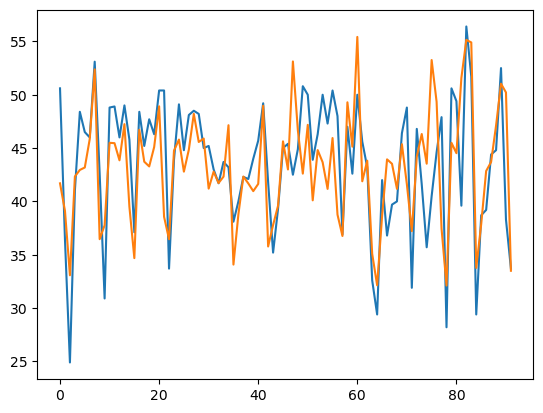

In [42]:
plt.plot(np.array(y_test))
plt.plot(y_pred)
plt.show()